This code to explore space generalization of MLP.  
Its worth mentioned that the model structure is different from the one used to predict from 155 offshore to 145 nearshore. The input size has been changed (decreased) to predict only part of the coastline.

In [ ]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 8.0 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import convert_deg_to_sin_cos,normalize,MLPDataset, mlptrain,mlpvalidate,generate_random_numbers

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


The strategy, currently, is to split the sapce continiously into 5 chunks and train a model on some the chunks, test them on others.

In [ ]:
# mlp model with flexible input and output shape

class simpleFFN(nn.Module):
  def __init__(self,indim,outdim):
    super(simpleFFN, self).__init__()
    self.hidden_1 = nn.Linear(indim, 50, bias=False)
    self.hidden_2 = nn.Linear(50, 50, bias=False)
    self.hidden_3 = nn.Linear(50,50)
    self.output = nn.Linear(50, outdim, bias=False)
    self.activation = nn.LeakyReLU()

  def forward(self, X):
    z1 = self.hidden_1(X)
    a1 = self.activation(z1)
    z2 = self.hidden_2(a1)
    a2 = self.activation(z2)
    z3 = self.hidden_3(a2)    ### modified forward pass to use the new layer
    a3 = self.activation(z3)  ### activate the output of the new layer
    z4 = self.output(a3)      ### and now pass it to the output layer
    a4 = self.activation(z4)
    return a4



In [ ]:
#split the data into 5 chunks

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
# m25del = m25[[45,83,77],...]
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
# m0del = m0[[45,83,77],...]
m0 = np.delete(m0, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m0)}")


m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#  chucnk the tar
tar = m0[:,:,:,2]
print(tar.shape)
tar = np.reshape(tar,(np.shape(tar)[0],np.shape(tar)[1],int(np.shape(tar)[2]/5), 5))

tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2],np.shape(tar)[3]))
print(f"After reshaping: {tar_rs.shape}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"After reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
print('after FE')
feature25m = convert_deg_to_sin_cos(feature25m)

# chunk the features
feature25m = np.reshape(feature25m,(np.shape(feature25m)[0],int(np.shape(feature25m)[1]/5),5, np.shape(feature25m)[-1]))
feature25m = np.transpose(feature25m, (0, 1, 3, 2))
print(feature25m.shape)

#further reshape
print('Final reshaping')
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2],feature25m.shape[-1])
print(feature25m.shape)

tar_rs[np.isnan(tar_rs)] = 0
tar_rs = np.flip(tar_rs,axis=2)# as the index order of points is opposite for coastline and offshore, flip the offshore points by space index

Before reshaping: (185, 98, 155, 6)
Before reshaping: (185, 98, 155, 6)
Before reshaping: (185, 98, 145, 6)
(185, 97, 145)
After reshaping: (17945, 29, 5)
After reshaping: (17945, 155, 6)
After reshaping: (17945, 155, 6)
after FE
(17945, 31, 8, 5)
(17945, 31, 8, 5)
Final reshaping
(17945, 248, 5)
(17945, 248, 5)


In [ ]:
seed = 42
lr = 1e-4
# momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 80

In [ ]:
def trainwithout(feature,target):
    """
    Train a simple Feed Forward Neural Network (FFN) on given features and targets.
    The function uses the Mean Squared Error (MSE) loss and Adam optimizer.

    Parameters:
    - feature (numpy.ndarray): The feature matrix.
    - target (numpy.ndarray): The target matrix.

    Steps:
    1. Normalizes the feature matrix.
    2. Splits the data into training and testing sets.
    3. Creates DataLoader objects for training and validation.
    4. Initializes the FFN model and moves it to the device (presumably GPU).
    5. Trains the model using batches from DataLoader and updates the model parameters.
    6. Validates the model on the validation set.
    7. Plots the training and validation losses during training.

    Returns:
    - mean (numpy.ndarray): The mean used to normalize the features.
    - std (numpy.ndarray): The standard deviation used to normalize the features.
    - model (torch.nn.Module): The trained PyTorch model.

    Note:
    - This function uses global variables for batch_size, test_batch_size, n_epochs, and device.
      Ensure these are available in your workspace.
    """

    mean,std,feature = normalize(feature)

    indim = feature.shape[-1]
    outdim = target.shape[-1]
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)

    traindata = MLPDataset(X_train,y_train)
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    valdata = MLPDataset(X_test,y_test)

    model = simpleFFN(outdim=outdim,indim=indim).to(device)                                              # instantiate model and send it to the GPU
    criterion = nn.MSELoss()

    train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
    validation_loader = DataLoader(valdata, batch_size=test_batch_size, shuffle=False, num_workers=0)

    # built in lr (e-4)
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
    liveloss = PlotLosses()    # plots evolution of loss and accuracy
    for epoch in range(n_epochs):
        logs = {}
        train_loss= torch.sqrt(mlptrain(model, optimizer, criterion, train_loader,device=device))

        logs['' + 'log loss'] = train_loss.item()
        # logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss= torch.sqrt(mlpvalidate(model, criterion, validation_loader, device=device))
        logs['val_' + 'log loss'] = validation_loss.item()
        # logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        print(validation_loss.item())


    return mean, std, model

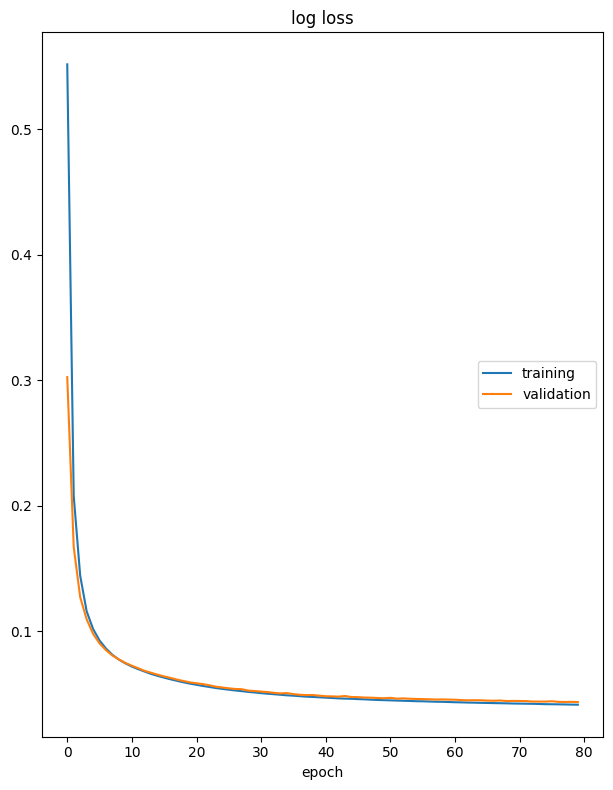

log loss
	training         	 (min:    0.041, max:    0.552, cur:    0.041)
	validation       	 (min:    0.043, max:    0.302, cur:    0.043)
0.04343293979763985


In [ ]:
meanmid, stdmid, modelmid = trainwithout(feature25m[...,2],tar_rs[...,2])# use the 3rd chunk to train a model

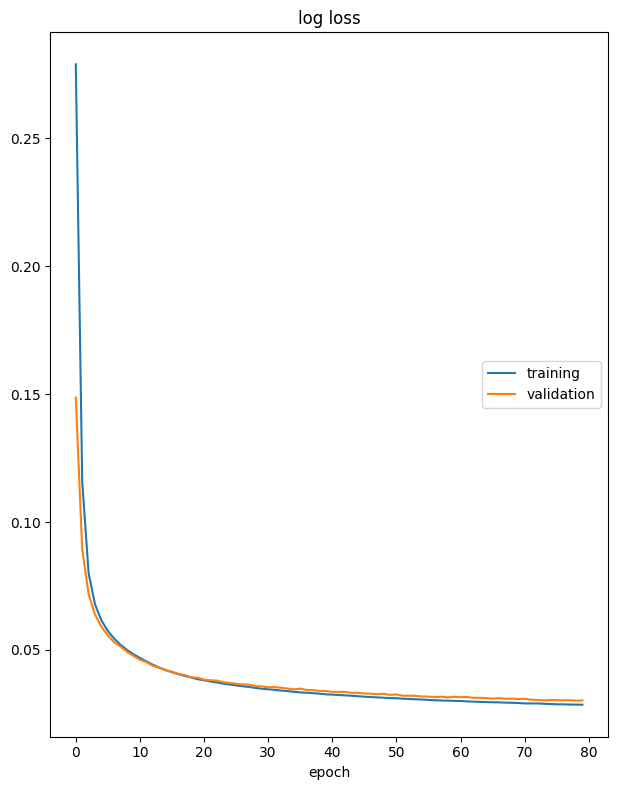

log loss
	training         	 (min:    0.029, max:    0.279, cur:    0.029)
	validation       	 (min:    0.030, max:    0.149, cur:    0.030)
0.03023815155029297


In [ ]:
meanleft,stdleft,modelleft = trainwithout(feature25m[...,0],tar_rs[...,0])

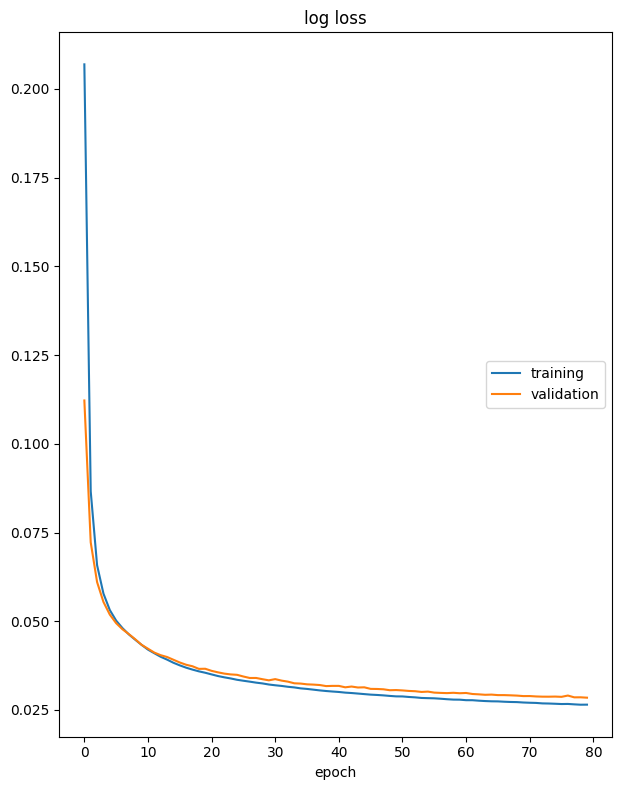

log loss
	training         	 (min:    0.026, max:    0.207, cur:    0.027)
	validation       	 (min:    0.028, max:    0.112, cur:    0.028)
0.02846776507794857


In [ ]:
meanright, stdright, modelright = trainwithout(feature25m[...,-1],tar_rs[...,-1])

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#normalization
def normalize(arr):
    """
    Normalizes a NumPy array.

    Parameters:
    arr (np.array): Input array to be normalized.

    Returns:
    mean (float): Mean of the input array along axis 0.
    std (float): Standard deviation of the input array along axis 0.
    arr_normalized (np.array): Normalized array.

    Note:
    - This function is different from the one in utilities.py
    """
    # Compute mean and std dev
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)

    # Subtract mean and divide by std dev
    arr_normalized = (arr - mean) / std

    return mean, std, arr_normalized

In [ ]:
def spacegener(mean,std,model,mode):
  """
  Generate predictions for different spatial rhunks using a pre-trained model and
  evaluates these predictions against actual target values. Optionally plots the results.
  The mean and std are expected to be the ones of the chunk data modeled train with. used to normalize data on every chunk
  Steps:
  1. Loops through each target dimension in `tar_rs`.
  2. Normalizes the features if mode is 0, or scales them using the provided mean and std if mode is 1.
  3. Makes predictions using the pre-trained model. Plot prediction for randomly chosen samples.
  4. Calculates the Root Mean Square Error (RMSE) between the predictions and actual targets.
  5. Optionally plots the results if mode is 0.

  Note:
  - This function assumes the presence of global variables such as `feature25m` and `tar_rs`.
    It's advisable to pass these as parameters for a more robust implementation.
  - The function also assumes that PyTorch's device (CPU or GPU) is globally defined as `device`.
  """
  mselist =[]

  for i in range(tar_rs.shape[-1]):
    if mode == 0:
      #use the mean and std of the feature, but not the chunk model trained on, see if better
      feature = feature25m[...,i]
      mean,std,feature = normalize(feature)
      feature = torch.tensor(feature).to(device).float()
    if mode == 1:
      feature =torch.tensor((feature25m[...,i]-mean)/std).to(device).float()

    tar = tar_rs[...,i]
    pre = model(feature)
    mselist.append(mse(pre.cpu().detach().numpy(),tar)**0.5)

    if mode == 0:
      fig = plt.figure(figsize=(12, 12))
      fignum = 9
      for ind,num in enumerate(generate_random_numbers(fignum, 0, 147)):
          plt.subplot(3, 3, ind+1)
          plt.plot(pre[num].cpu().detach().numpy(), label=f'model res') # -1 here, use the last of the sequence as output
          plt.plot(tar[num], label=f'tar')

          plt.xlabel('nearshore point ind')
          plt.ylabel('SWH m')
          plt.title(f'inbatch_ind{i}')
          plt.legend()

    plt.suptitle(f'Test on space excluded_chunk{i+1}')
    plt.tight_layout()
    plt.show()

  return mselist

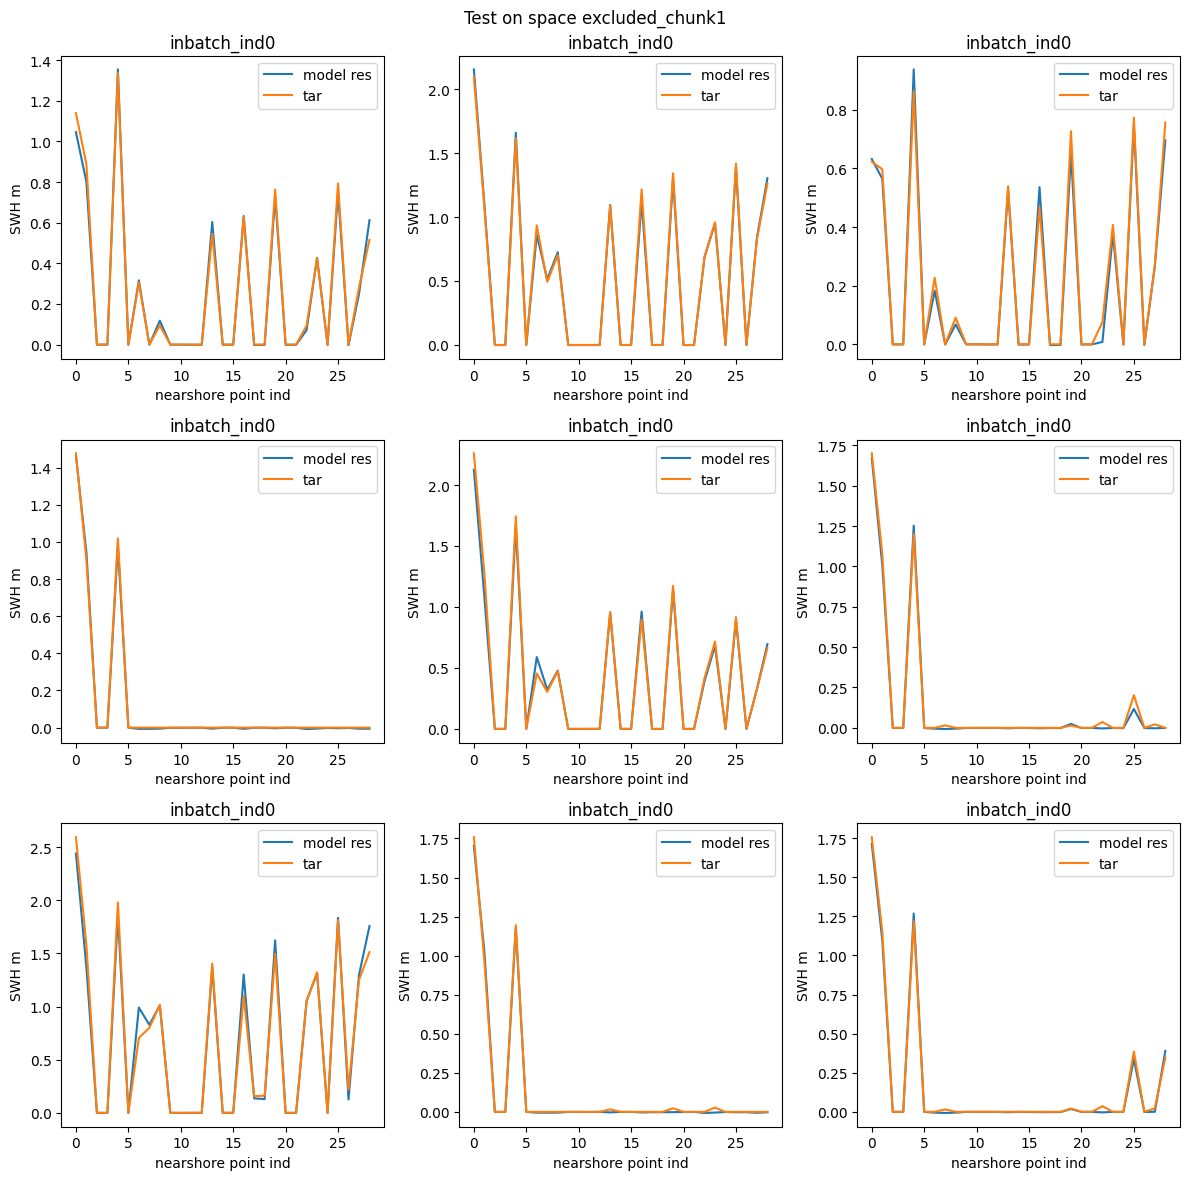

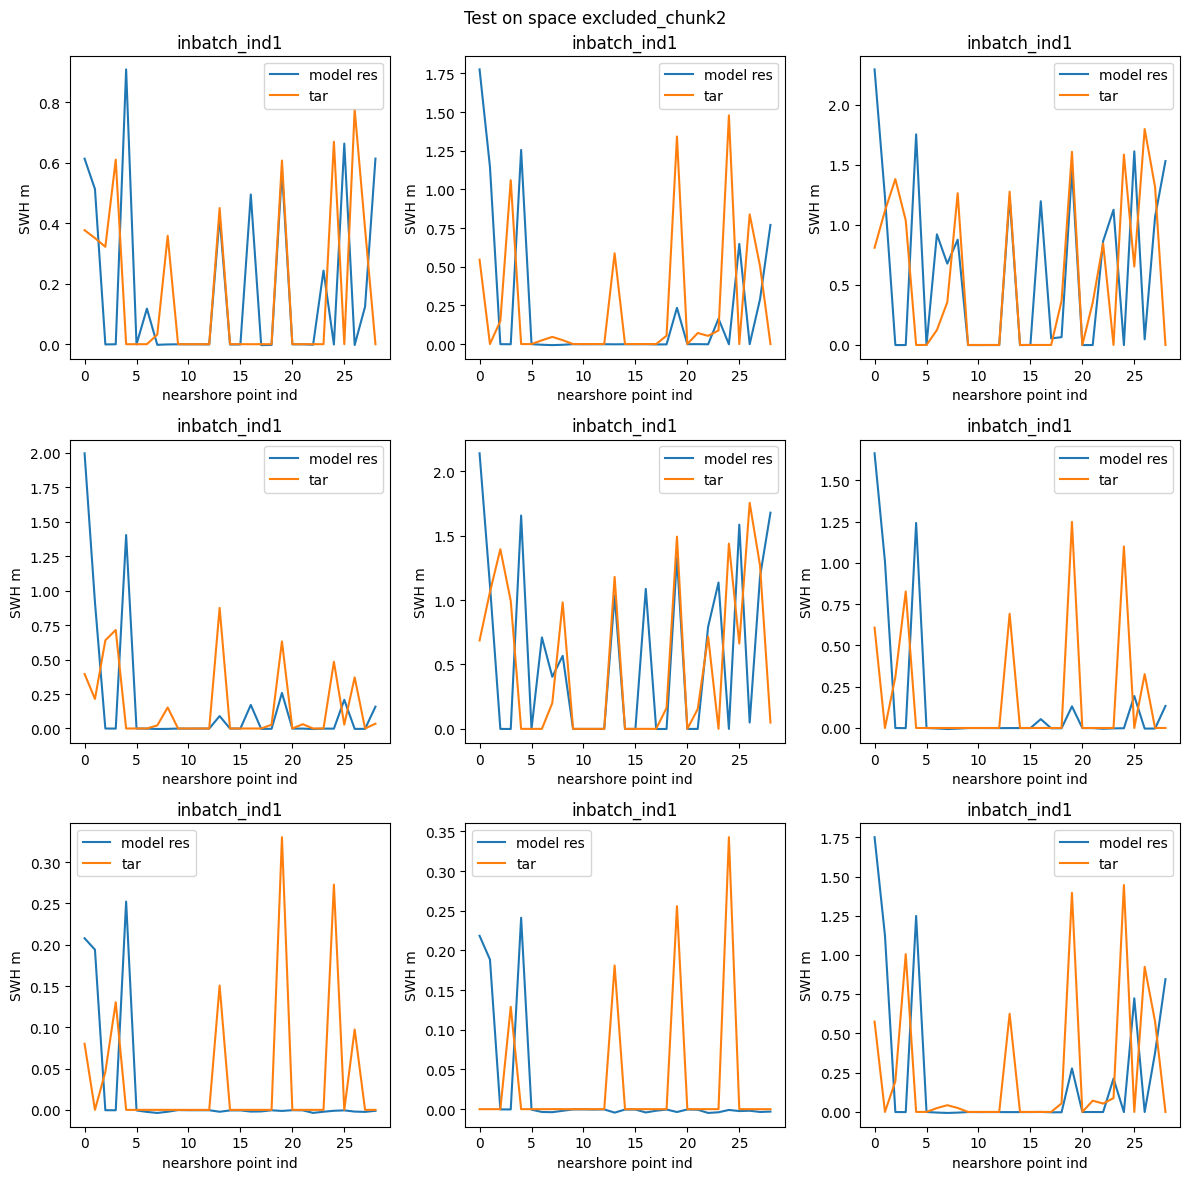

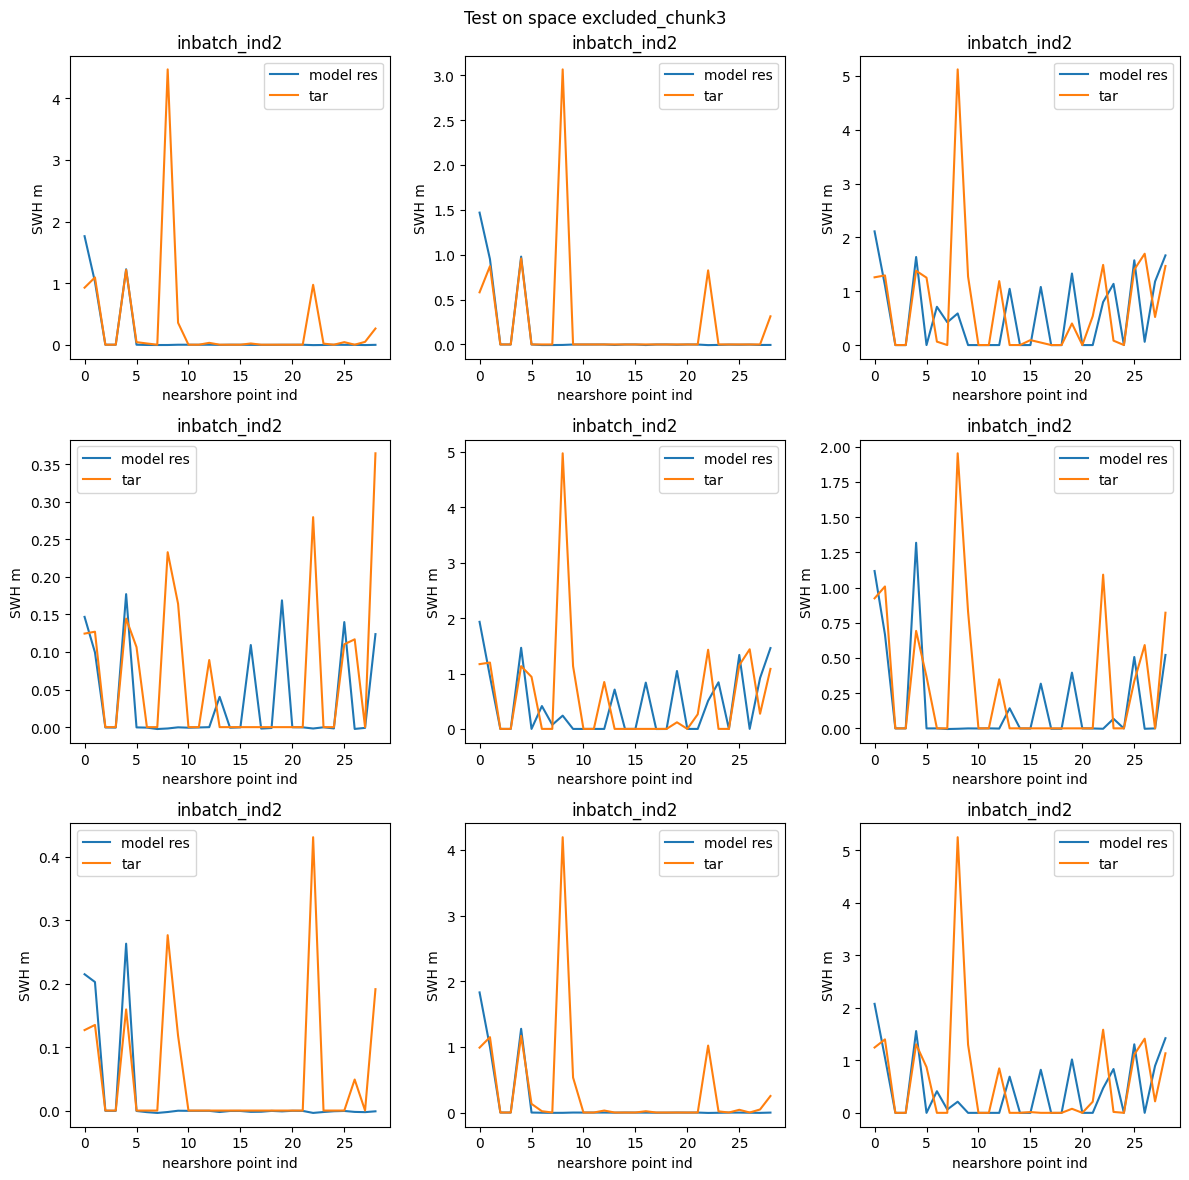

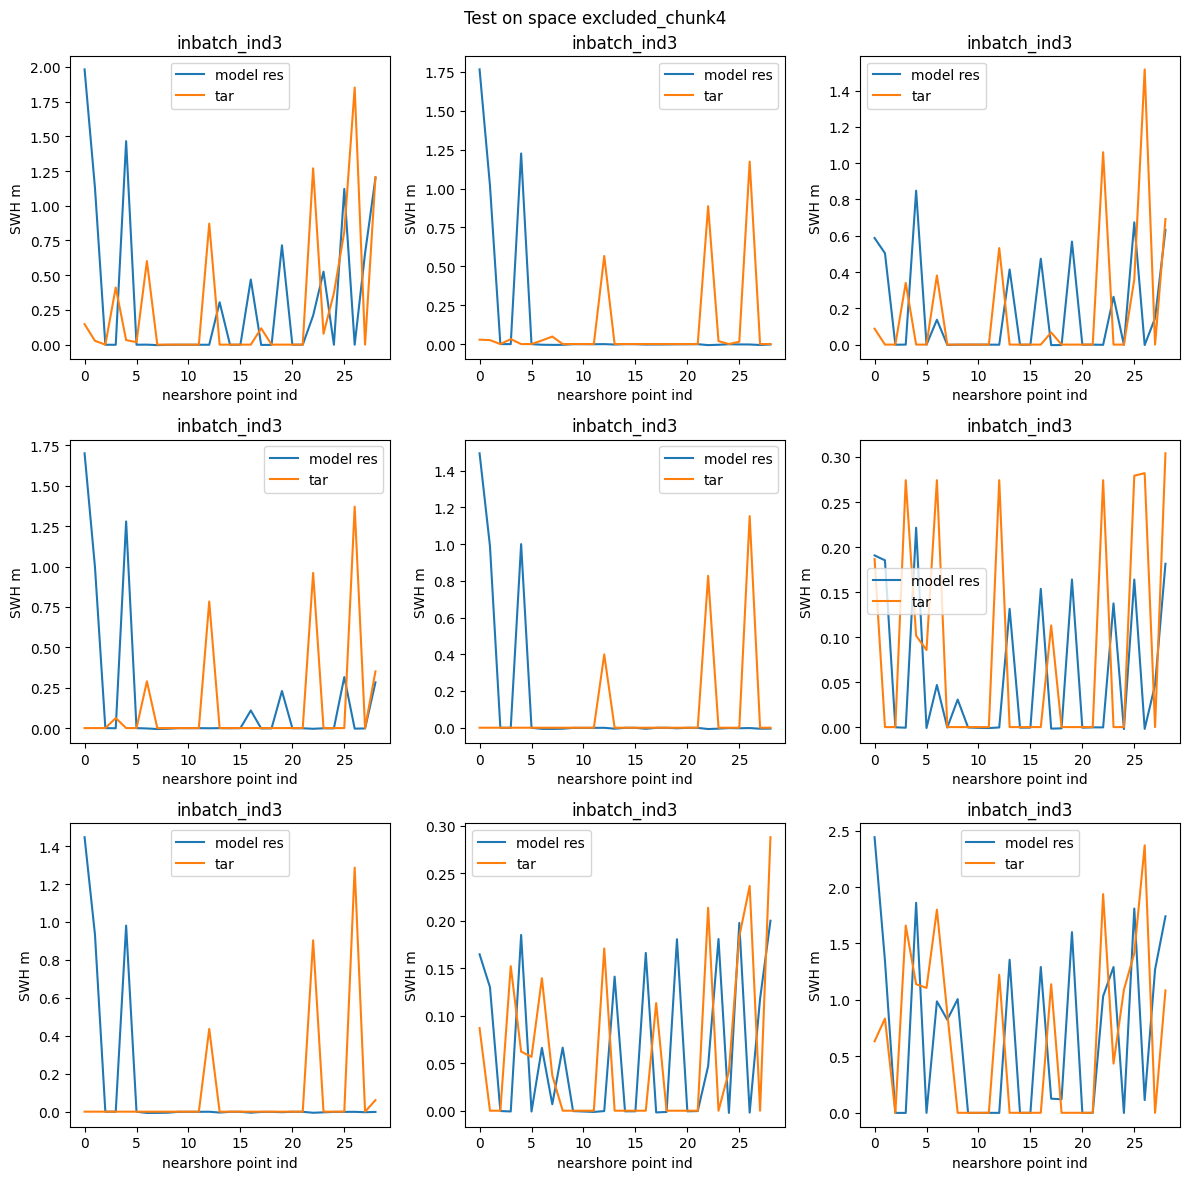

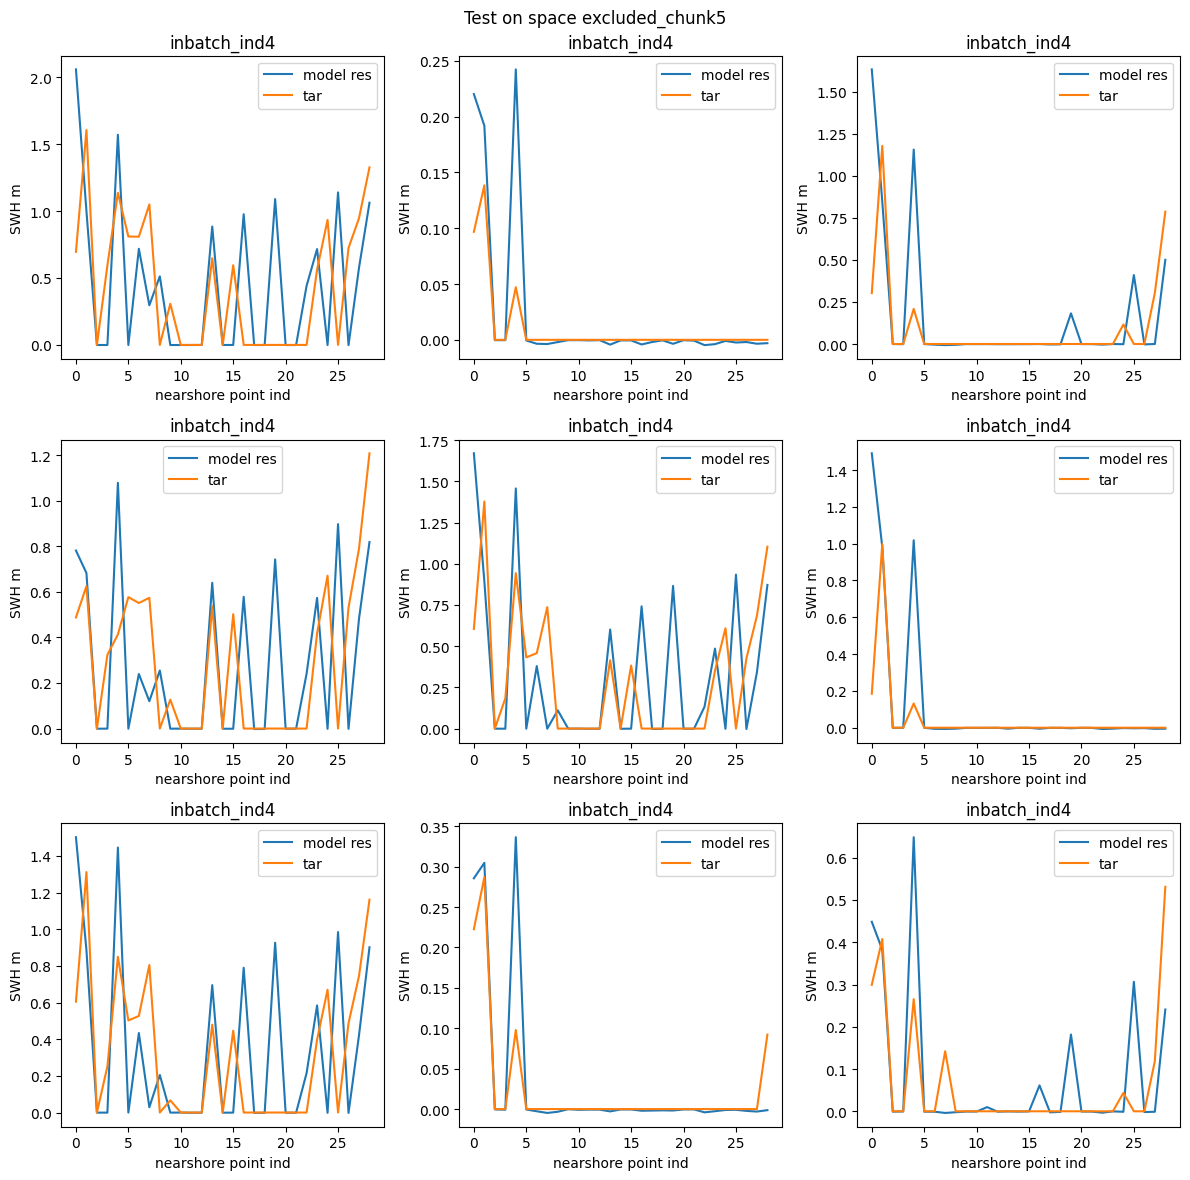

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

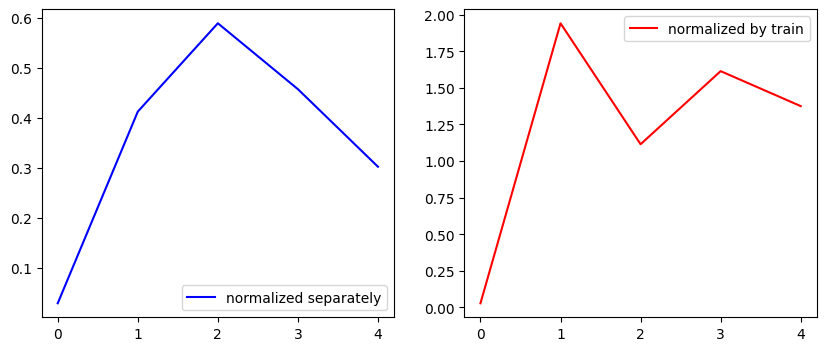

In [ ]:
# generalization for model trained on left chunk
leftlist0 = spacegener(meanleft,stdleft,modelleft,0)
leftlist1 = spacegener(meanleft,stdleft,modelleft,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(leftlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(leftlist1,label='normalized by train',color='red')
axes[1].legend()

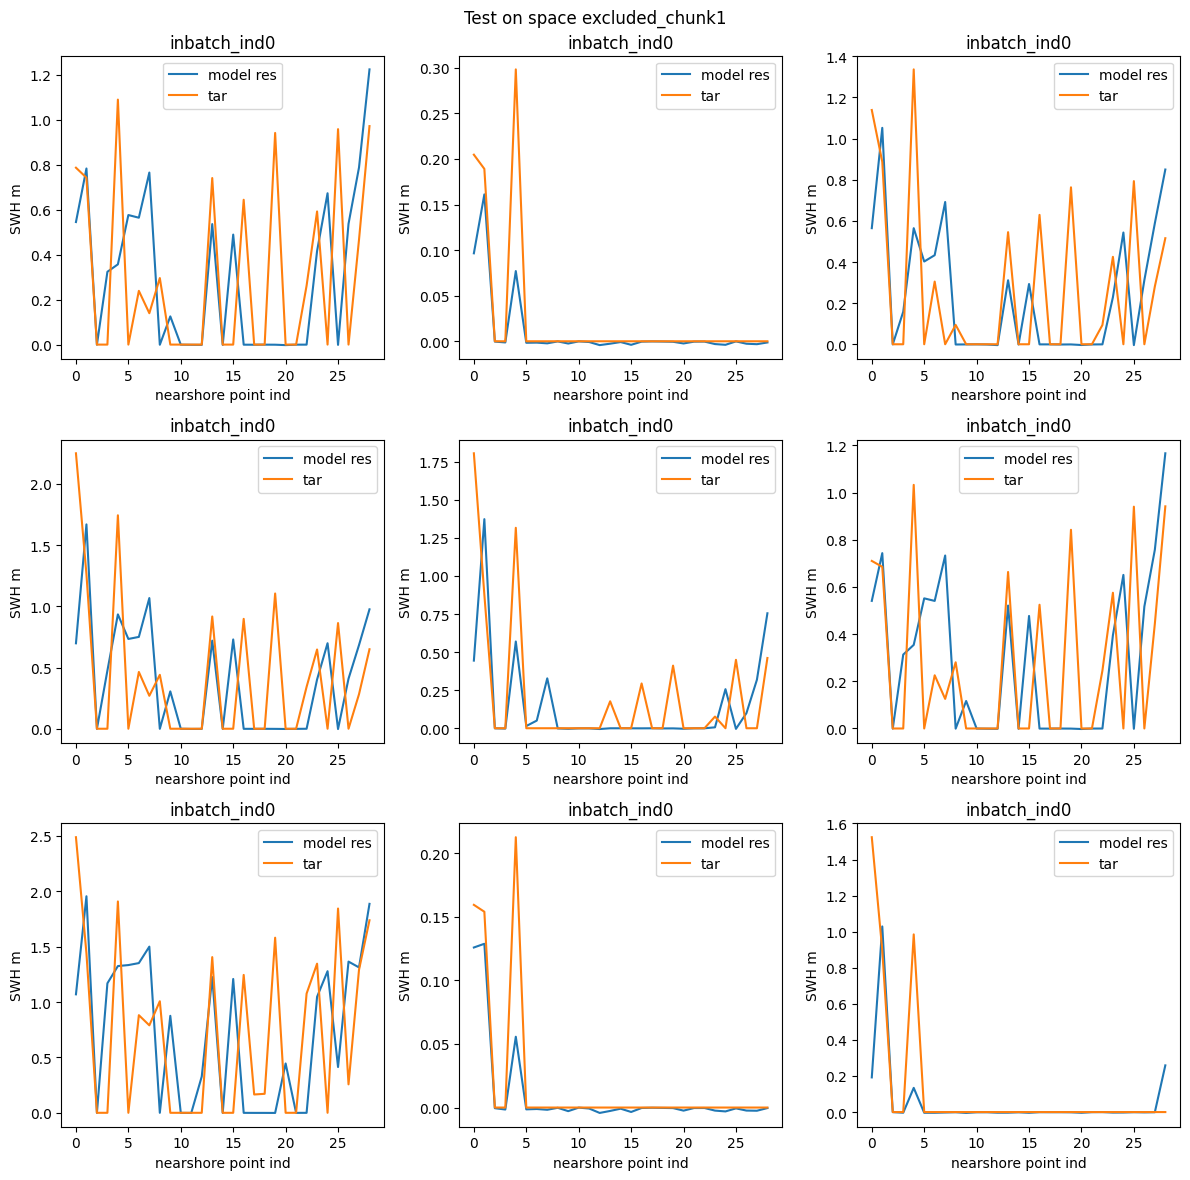

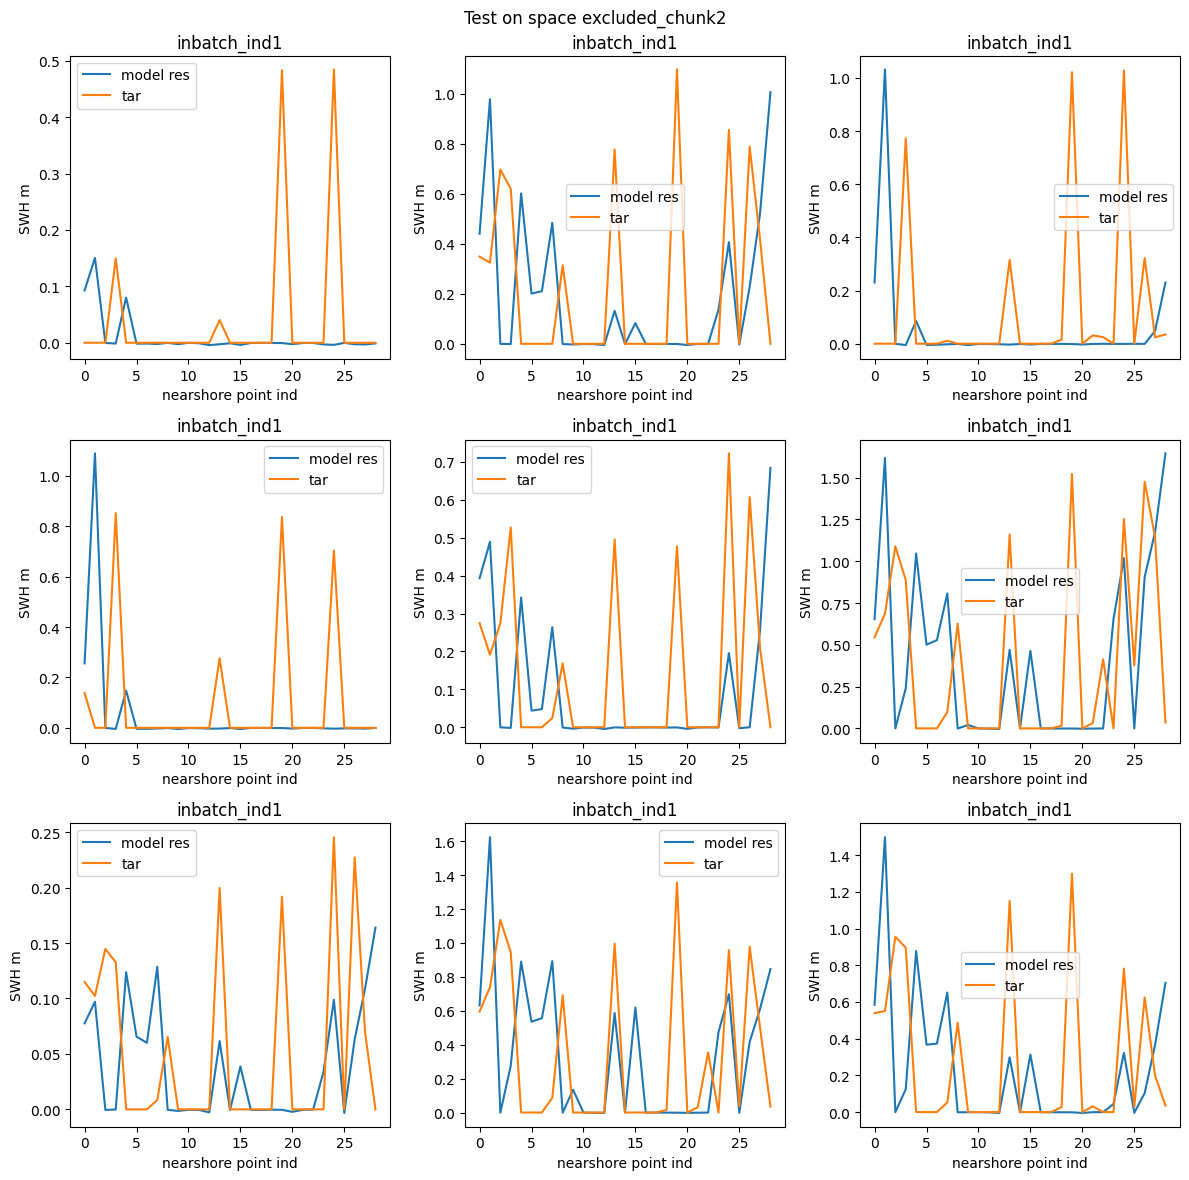

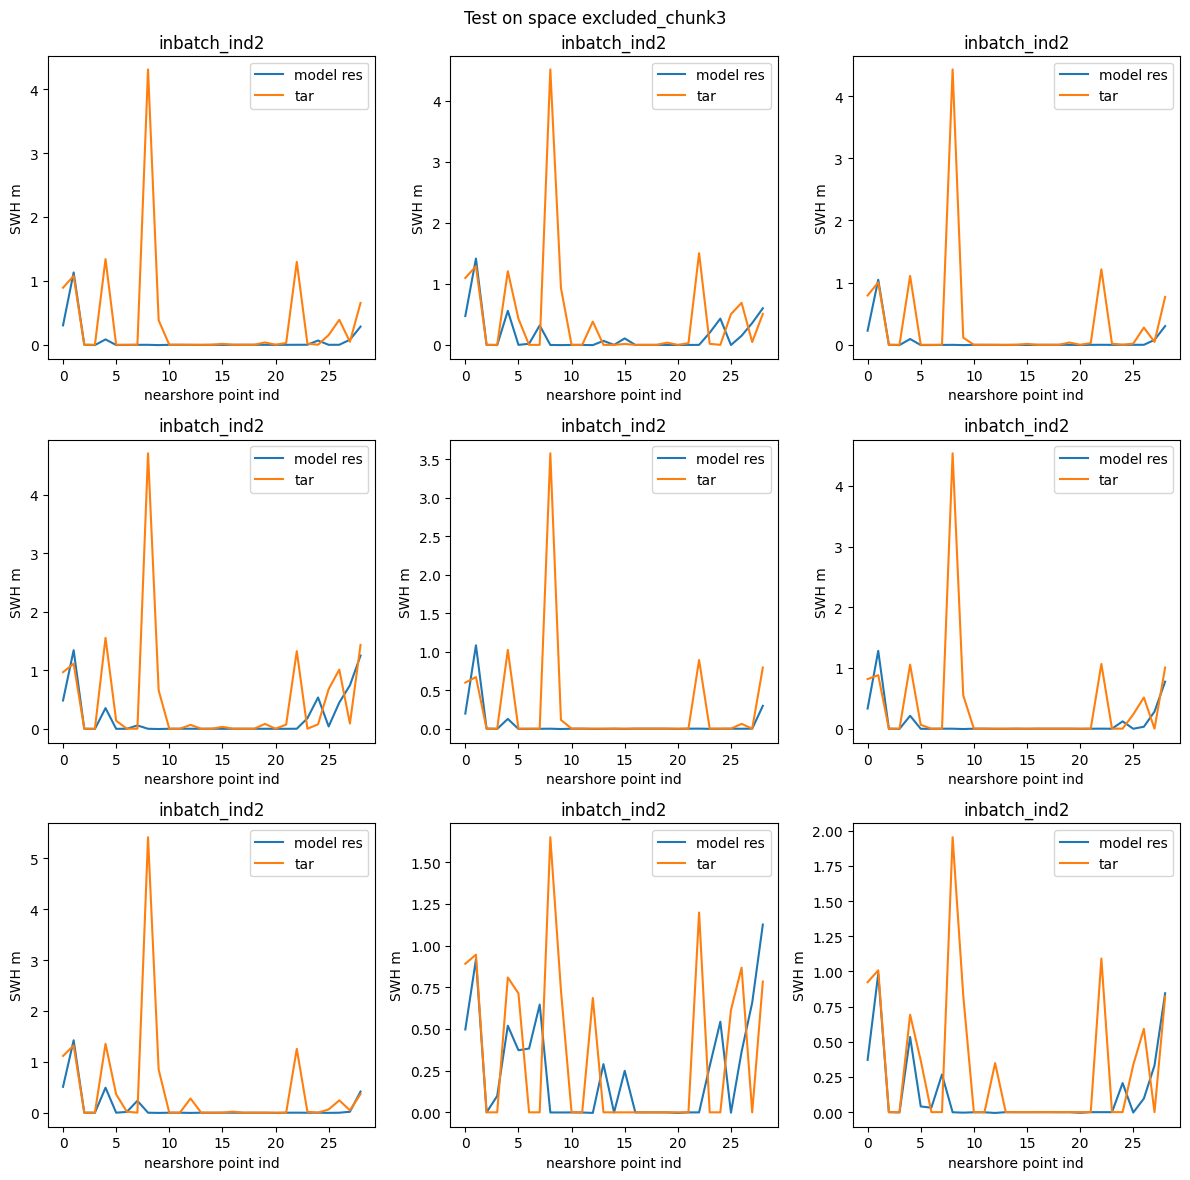

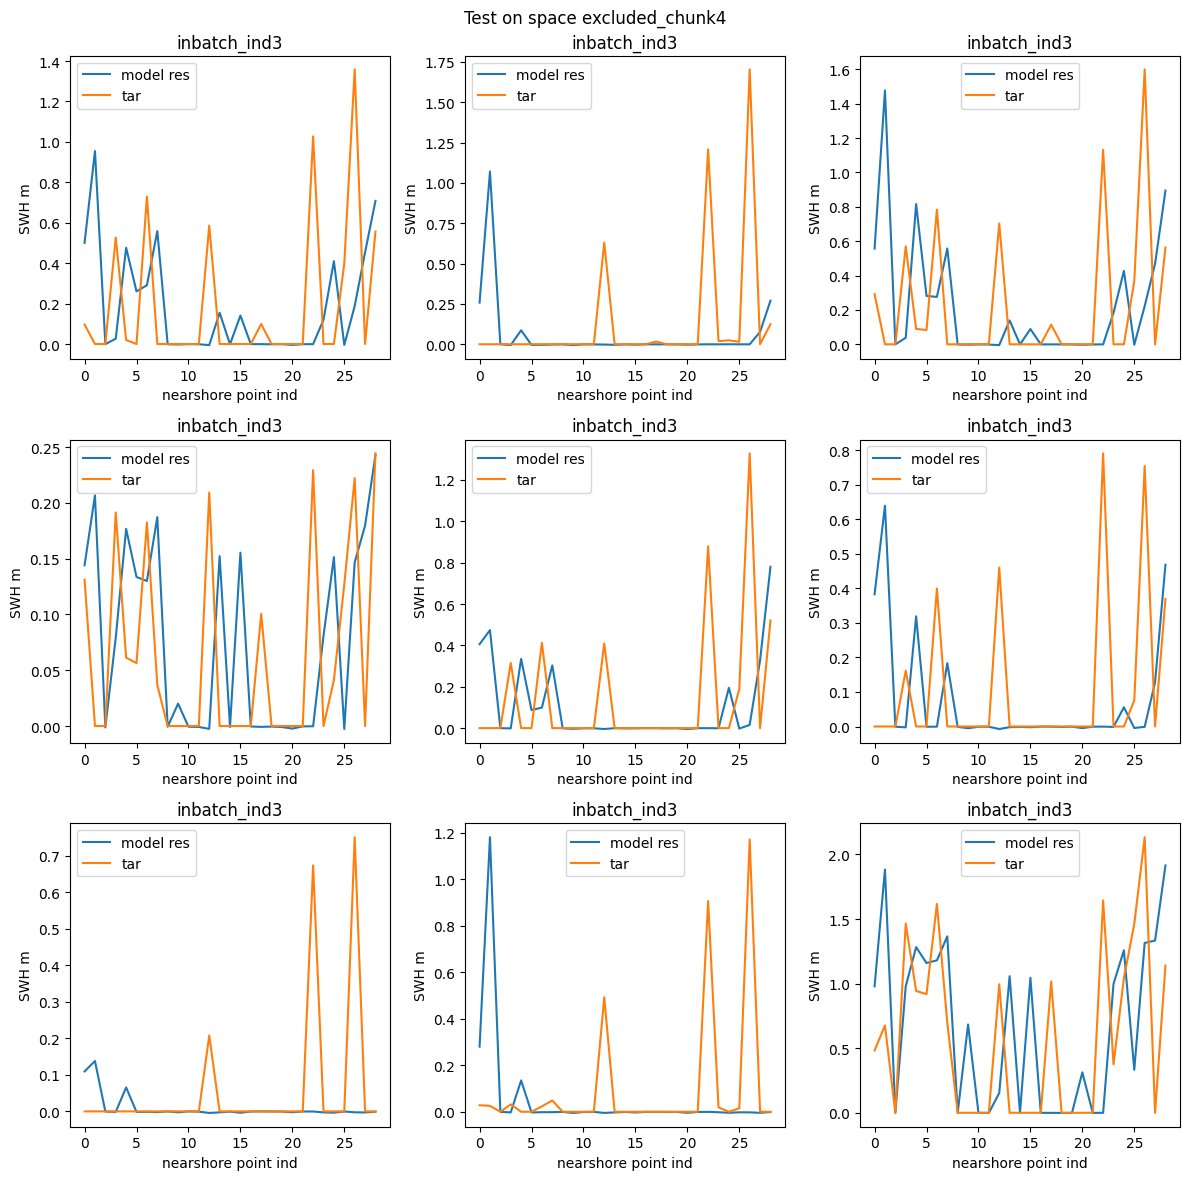

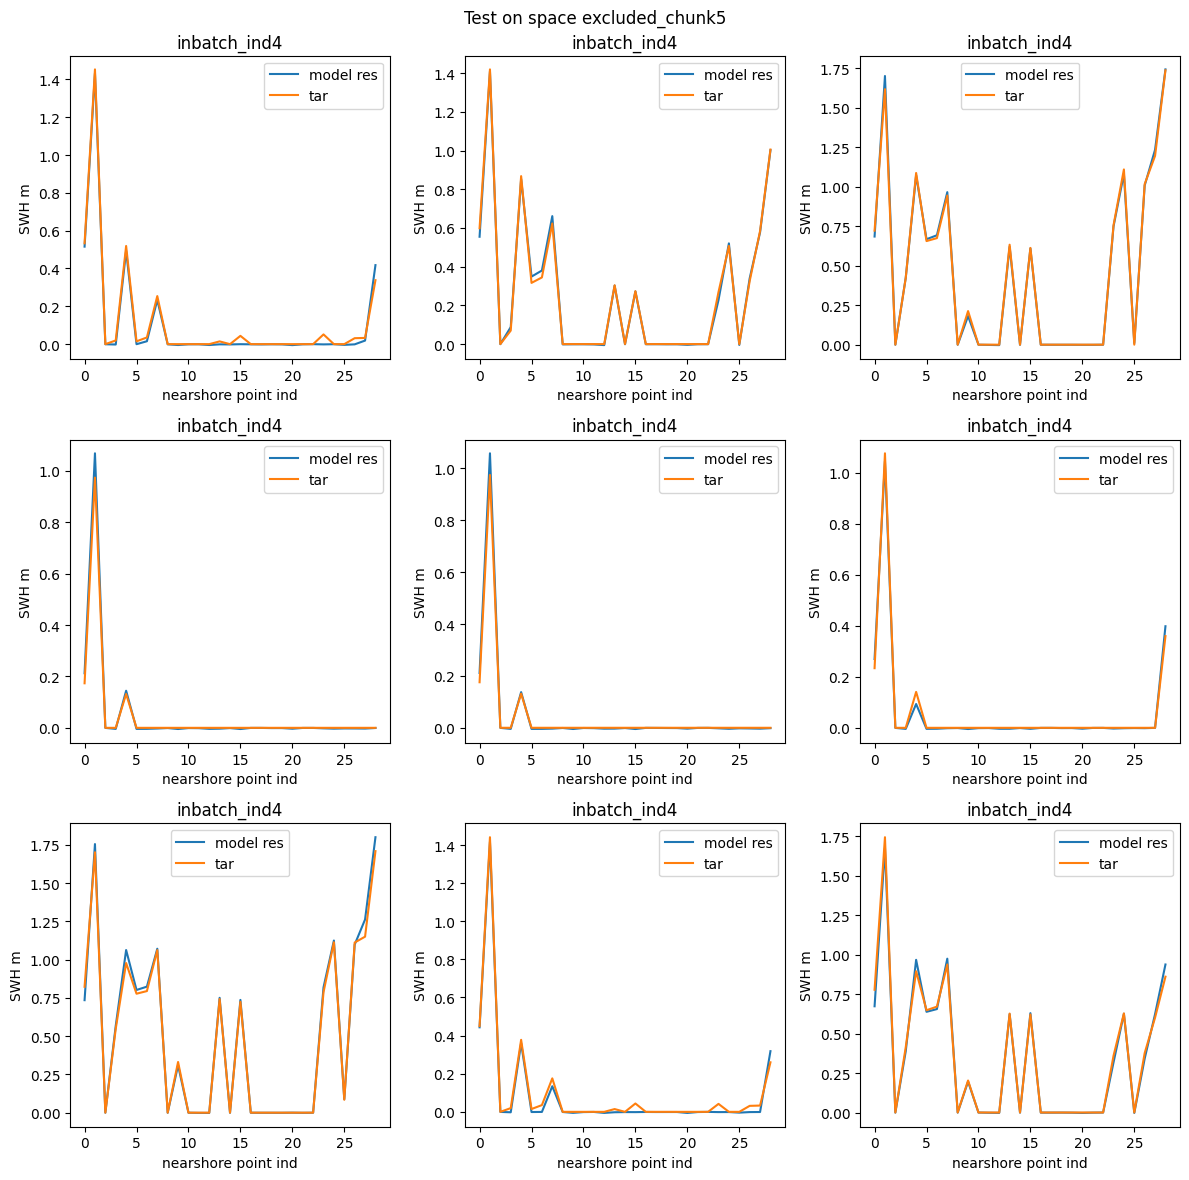

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

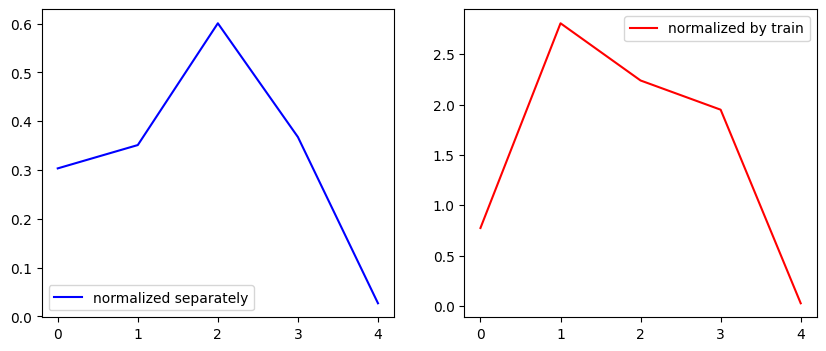

In [ ]:
# generalization for model trained on right chunk
rightlist0 = spacegener(meanright,stdright,modelright,0)
rightlist1 = spacegener(meanright,stdright,modelright,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(rightlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(rightlist1,label='normalized by train',color='red')
axes[1].legend()

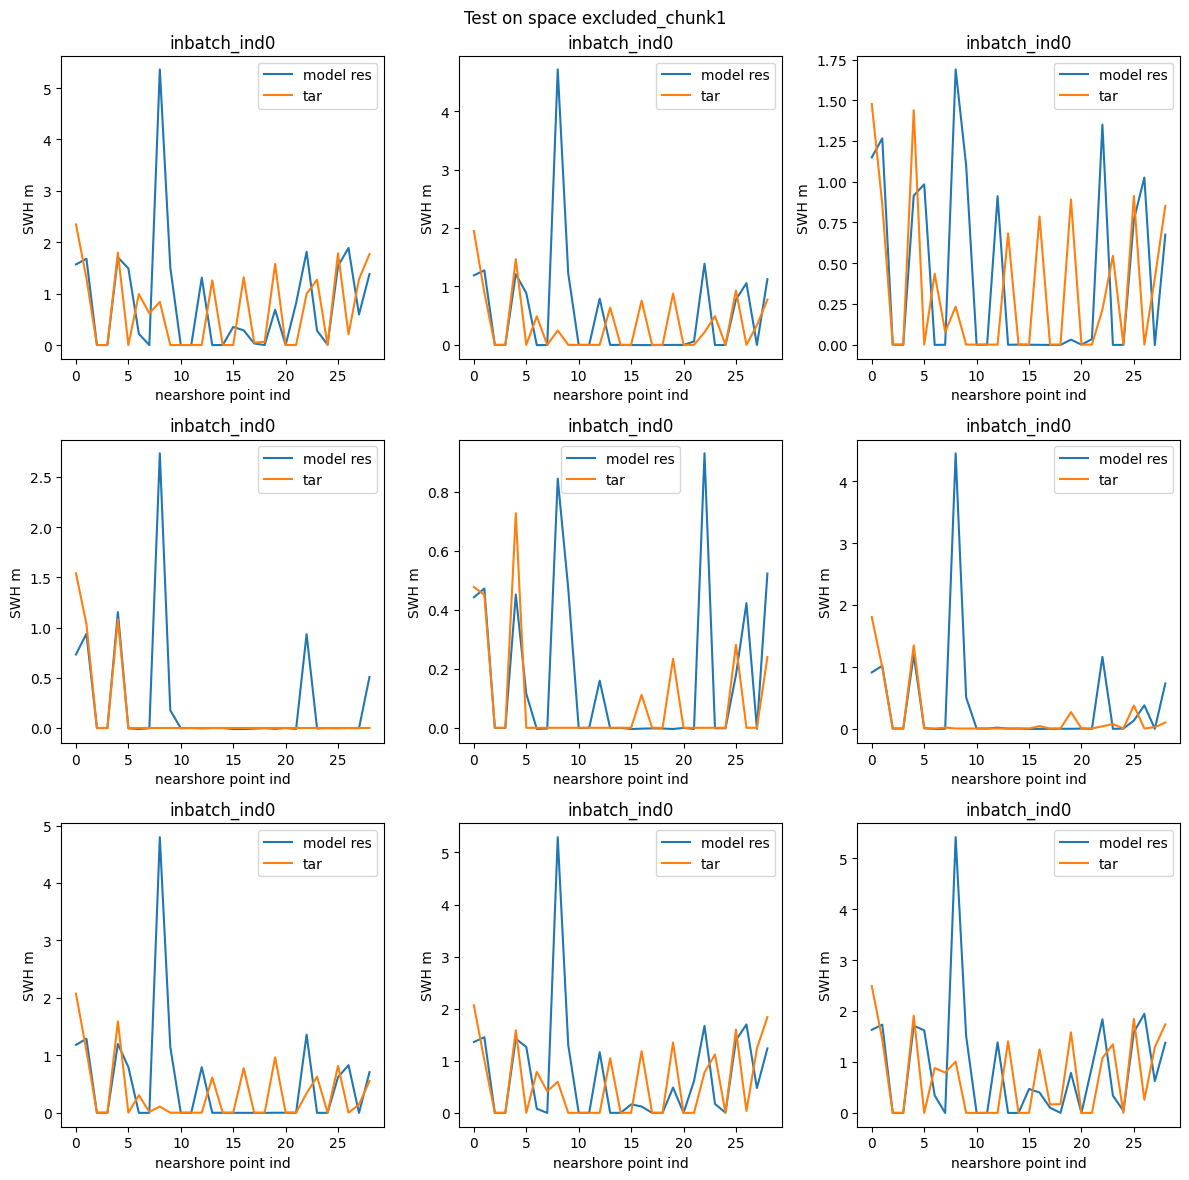

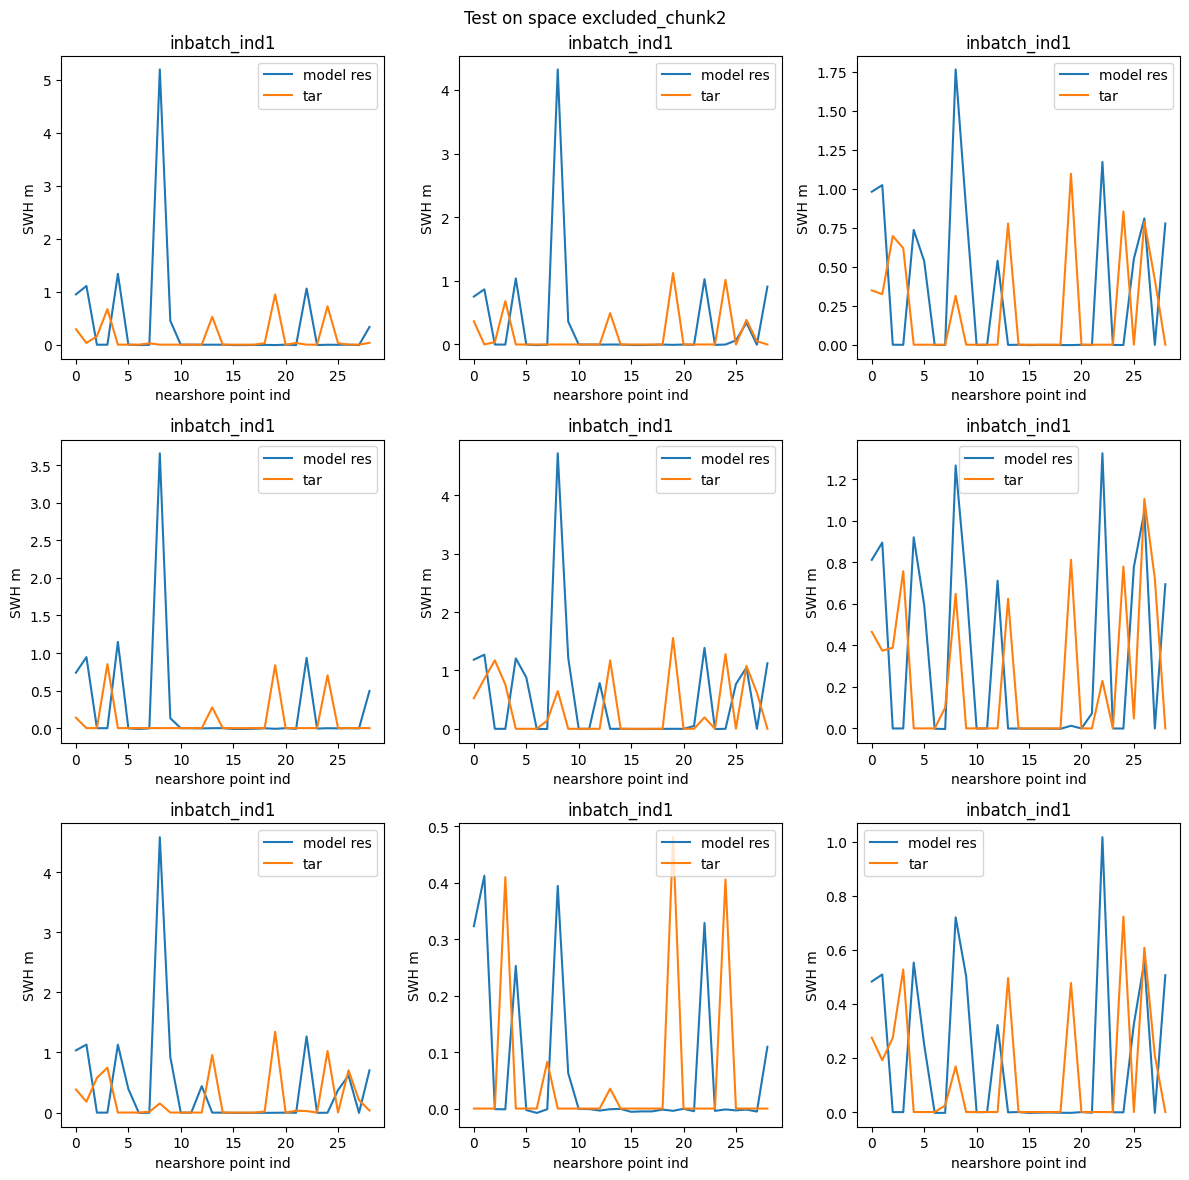

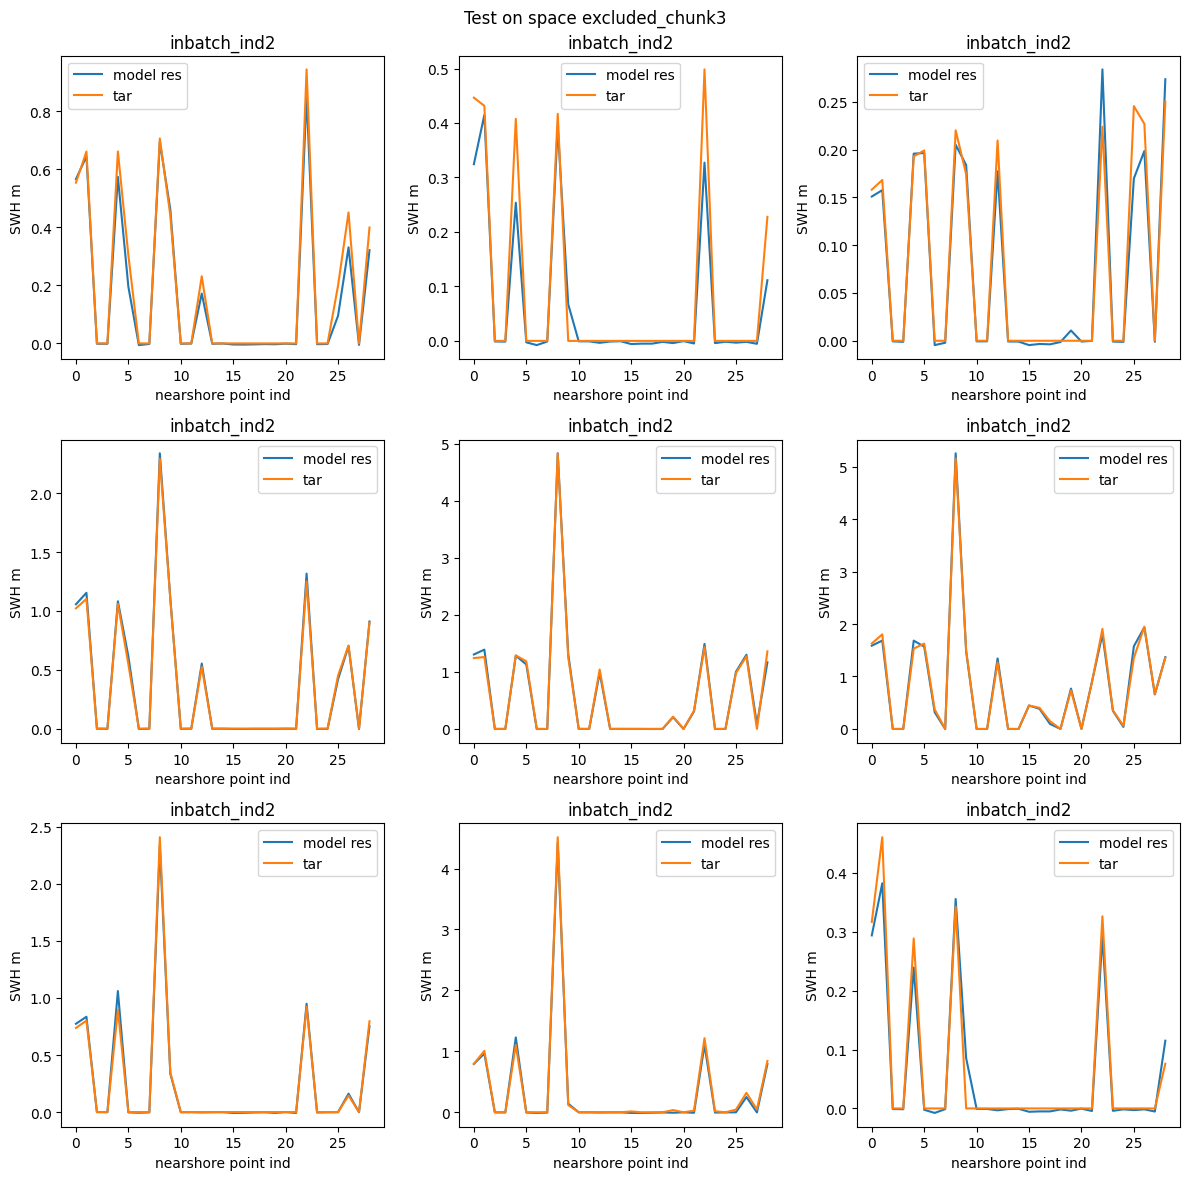

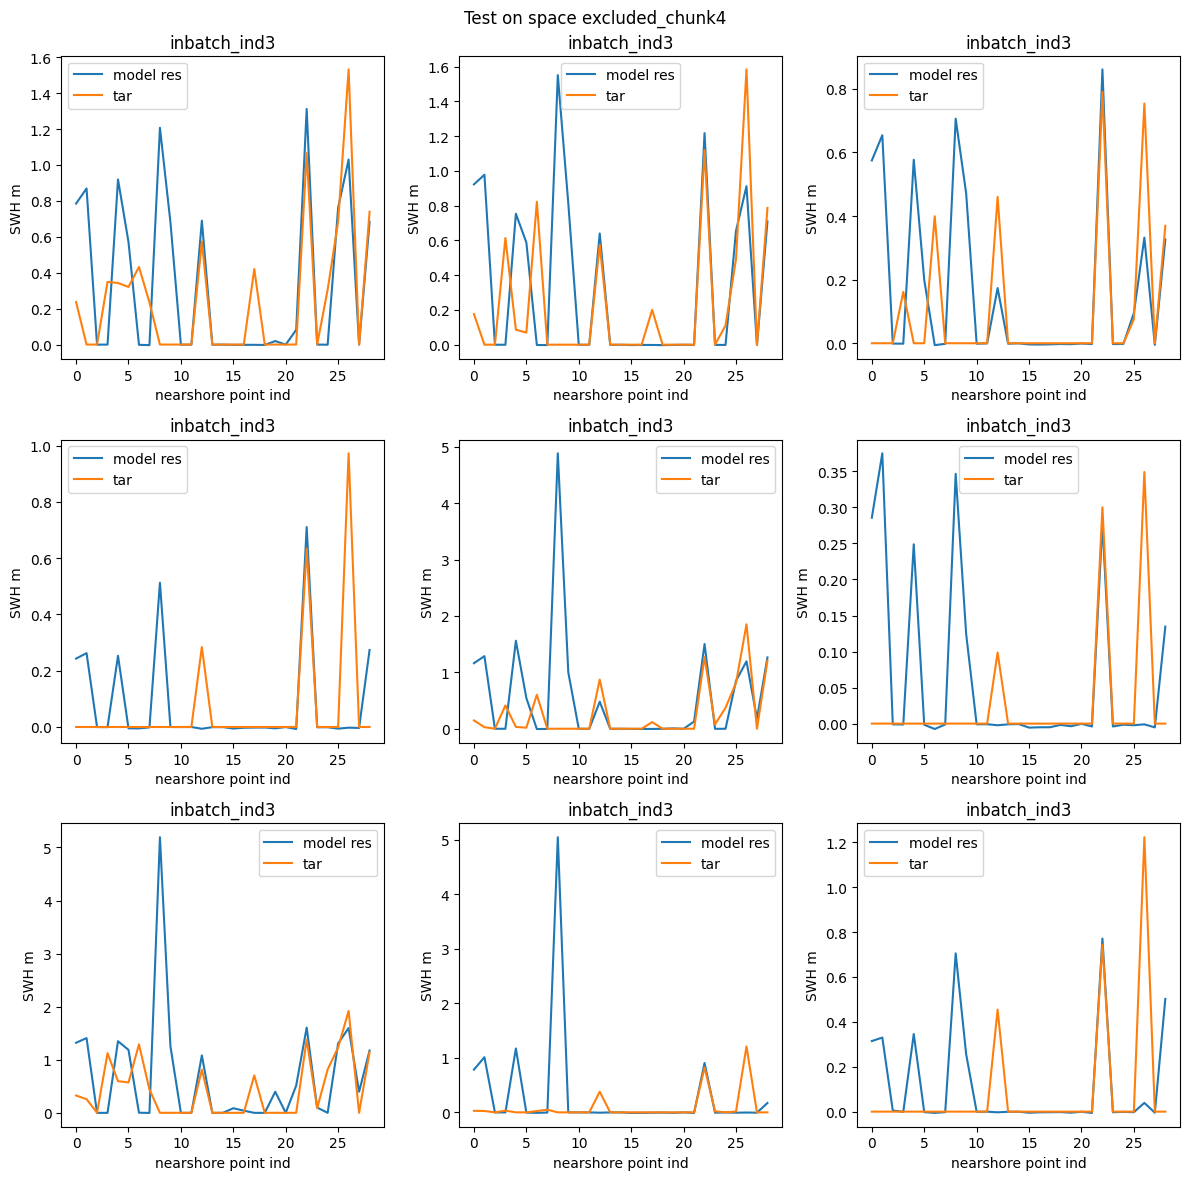

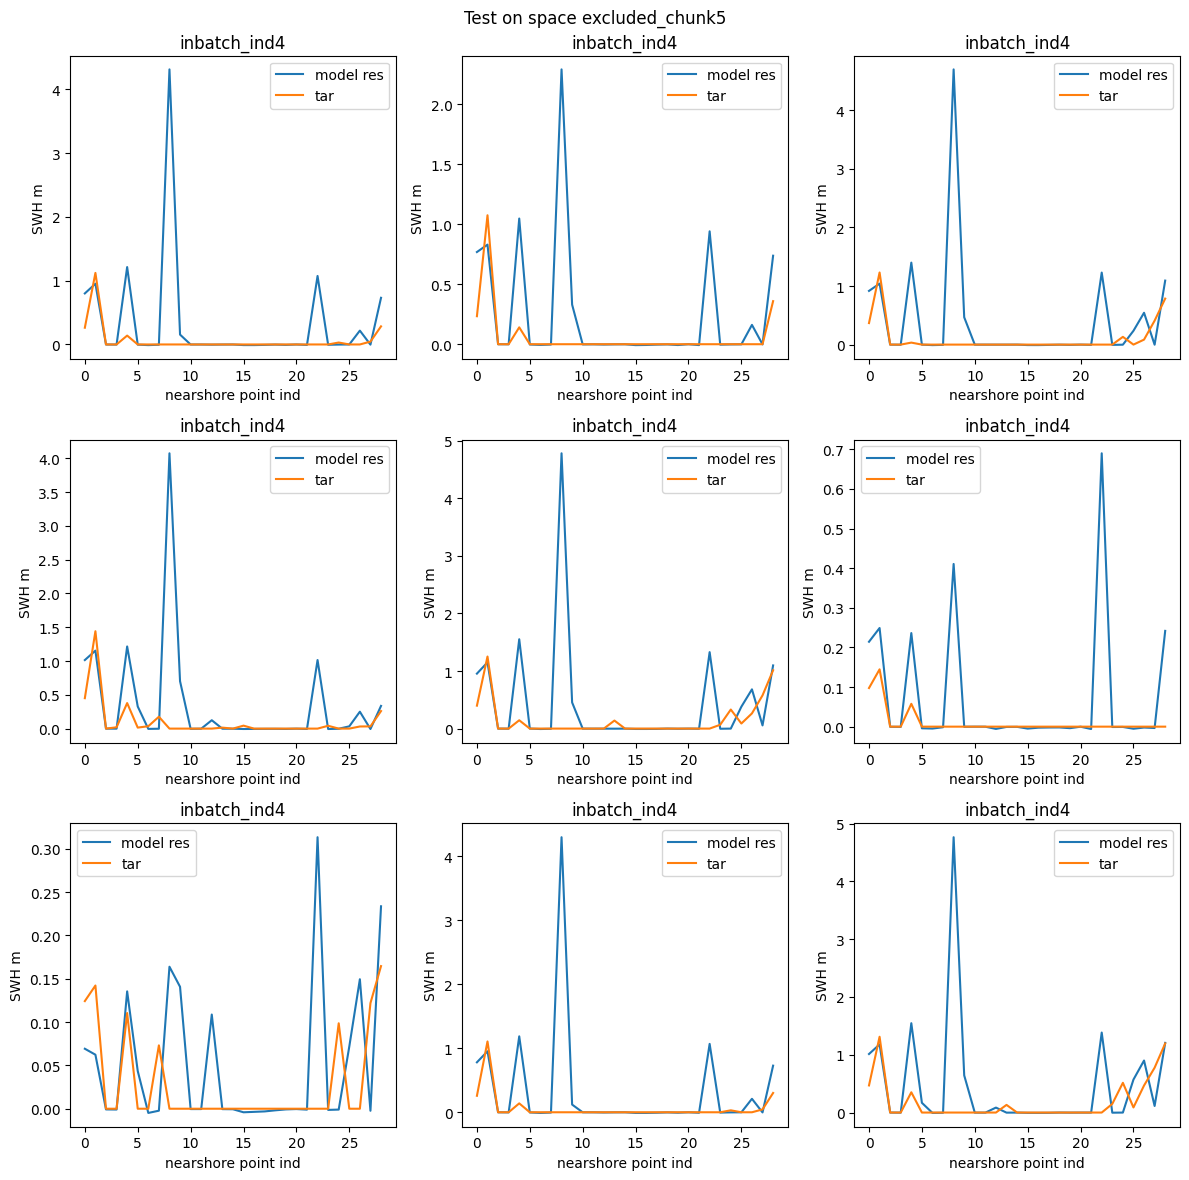

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

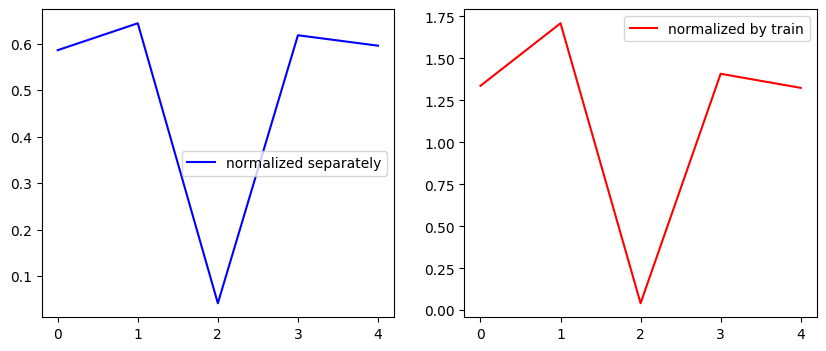

In [ ]:
# mid
midlist0 = spacegener(meanmid,stdmid,modelmid,0)
midlist1 = spacegener(meanmid,stdmid,modelmid,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(midlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(midlist1,label='normalized by train',color='red')
axes[1].legend()